# DVD Rental database
База представляет бизнес процессы магазина по аренде DVD.

В ней содержится 15 таблиц:

1. actor – хранит данные об актерах, включая их имя и фамилию.
2. film – хранит данные о фильмах, такие как название, год выпуска, продолжительность, рейтинг и т.д.
3. film_actor – хранит связи между фильмами и актерами.
4. category – хранит категории фильмов
5. film_category - хранит взаимосвязи между фильмами и категориями.
6. store – хранит данные магазина, включая управляющий состав и адрес.
7. inventory – хранит инвентарные номера фильмов по магазинам.
8. rental – хранит данные об аренде.
9. payment – хранит платежи клиентов.
10. staff – хранит данные персонала магазинов.
11. customer – хранит данные клиентов.
12. address – хранит адреса для персонала и клиентов.
13. city – хранит имена городов.
14. country – хранит названия стран.
15. language – хранит языки фильмов.

![схема базы](https://sp.postgresqltutorial.com/wp-content/uploads/2018/03/dvd-rental-sample-database-diagram.png)

**В таблице film удалены колонки rental_duration, rental_rate и replacement_cost. Стоимость определяется только по таблице payment**

У всех пользователей student_x есть доступ на чтение к этой базе данных. Название **dvdrental**.

## Задание
1. Проведите ABC анализ ассортимента. Выполняется ли для этих данных правило Парето? Если нет, то приведите подходящее на ваш взгляд разбиение
2. На основе полученного (общего) анализа ассортимента, оцените средний объем недельной выручки в каждой категории в привязке к дате начала аренды. В какой категории эта оценка имеет меньший разброс?
3. Используя оценки выручки из пункта 2 и категоризацию из пункта 1, постройте классификатор фильмов на основе актерского состава, языка, рейтинга (12+, 18+, см колонку rating) и продолжительности. При построении классификатора подберите пороговые значения для каждого класса так, чтобы максимизировать ожидаемую выручку. То-есть нужно предсказывать категории А,B,C. **Дополнительно, при сравнении моделей воспользуйтесь построением доверительных интервалов (t интервалов) для оценки диапазона значений метрик качества для каждого классификатора.**
4. В redash постройте дэшборд, отражающий динамику о кол-ве заказов каждую неделю, а также информацию о том какие фильмы ожидают возвращения в магазин и о клиентах (телефон, email), которые должны их вернуть.



In [ ]:
!pip install psycopg2

In [ ]:
import psycopg2
from math import sqrt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import model_selection
from statsmodels.stats.weightstats import _tconfint_generic
%matplotlib inline


DB_HOST = '89.223.95.138'
DB_USER = 'student_9'
DB_USER_PASSWORD = 'student_9'
DB_NAME = 'dvdrental'

In [ ]:
# Подключение к БД
conn = psycopg2.connect(host=DB_HOST, user=DB_USER, password=DB_USER_PASSWORD, dbname=DB_NAME)

## ABC анализ
Задание: Проведите ABC анализ ассортимента. Выполняется ли для этих данных правило Парето? Если нет, то приведите подходящее на ваш взгляд разбиение

In [ ]:
# Запрос на получение записей о фильмах и суммах платежей, полученных по каждому из них
abc_data = pd.read_sql_query("""SELECT title,
       Sum(amount) AS "amount"
FROM   film
       JOIN inventory
         ON film.film_id = inventory.film_id
       JOIN rental
         ON inventory.inventory_id = rental.inventory_id
       JOIN payment
         ON rental.rental_id = payment.rental_id
GROUP BY title  """, conn)
abc_data

,title,amount
0,Graceland Dynamite,173.77
1,Opus Ice,281.47
2,Braveheart Human,111.30
3,Rush Goodfellas,712.16
4,Wonderful Drop,228.55
...,...,...
953,Mockingbird Hollywood,592.29
954,Gathering Calendar,240.39
955,Drums Dynamite,346.98
956,Samurai Lion,420.06


###Первичный анализ данных

In [ ]:
# Проверка на отсутствие нулевых значений
abc_data['amount'].isnull().value_counts()

False    958
Name: amount, dtype: int64

In [ ]:
abc_data.describe()
# Большое отклонение от среднего, нужно проверить на аномалии

,amount
count,958.000000
mean,391.292547
std,171.140481
min,36.900000
25%,249.927500
50%,379.940000
75%,504.235000
max,930.620000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


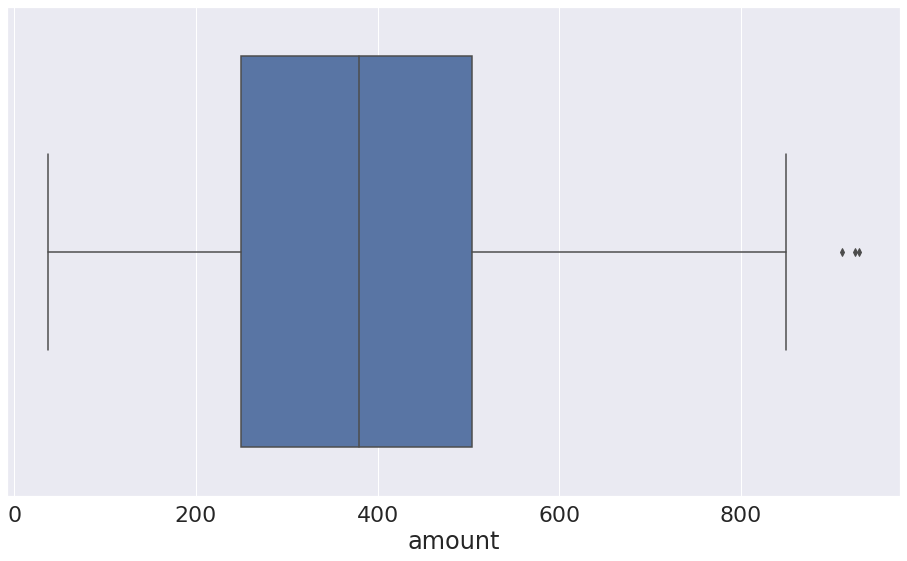

In [ ]:
# Проверка на аномалии
plt.rcParams.update({'font.size': 18, 'figure.figsize':(16,9)})
sns.boxplot(abc_data['amount'])

In [ ]:
# Посмотрим самые большие значения
abc_data['amount'][abc_data['amount'] > 800]
# Уберу значения больше 900

80     804.94
135    842.55
163    911.81
640    930.62
652    802.53
746    849.70
790    925.53
818    811.93
833    823.30
Name: amount, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


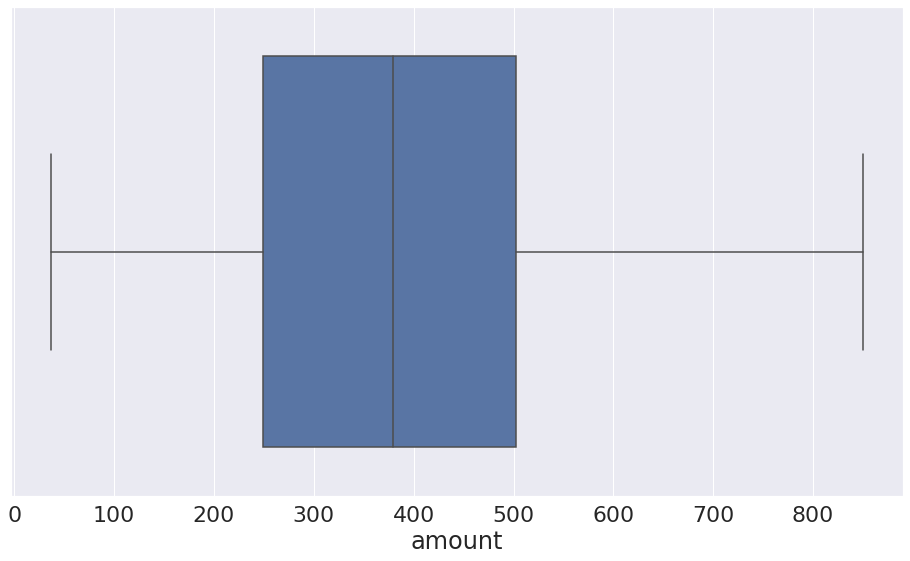

In [ ]:
# Повторная проверка на аномалии
abc_data = abc_data.drop(abc_data[abc_data['amount']>900].index)
sns.boxplot(abc_data['amount'])
# Теперь можно приступать к ABC анализу

### Классификация ресурсов

In [ ]:
# Общая выручка (по всем фильмам)
revenue = abc_data['amount'].sum()
print('Revenue: ', revenue)

Revenue:  372090.30000000005


In [ ]:
# Вклад каждого фильма в общую выручку
# contribution - вклад
abc_data['contribution'] = abc_data['amount'] / revenue
abc_data = abc_data.sort_values(by=['contribution'], ascending=False)
# Расчёт кумулятивной суммы
abc_data['cumsum'] = abc_data['contribution'].cumsum()
abc_data

,title,amount,contribution,cumsum
746,Gleaming Jawbreaker,849.70,0.002284,0.002284
135,Apache Divine,842.55,0.002264,0.004548
833,Deer Virginian,823.30,0.002213,0.006761
818,Storm Happiness,811.93,0.002182,0.008943
80,Greatest North,804.94,0.002163,0.011106
...,...,...,...,...
176,Cruelty Unforgiven,93.04,0.000250,0.999245
287,Mixed Doors,88.23,0.000237,0.999482
61,Slacker Liaisons,86.84,0.000233,0.999716
461,Flight Lies,68.88,0.000185,0.999901


In [ ]:
# Функция для классификации ресурсов
# 80% продаж - группа А
# 15% - группа B
# 5% - группа С
def ABC_analysis(percent):
  if percent < 0.8:
    return 'A'
  elif percent >= 0.8 and percent < 0.95:
    return 'B'
  else:
    return 'C'

In [ ]:
# Применение функции для классификации к стоблцу contribution
abc_data['category'] = abc_data['cumsum'].apply(ABC_analysis)
abc_data

,title,amount,contribution,cumsum,category
746,Gleaming Jawbreaker,849.70,0.002284,0.002284,A
135,Apache Divine,842.55,0.002264,0.004548,A
833,Deer Virginian,823.30,0.002213,0.006761,A
818,Storm Happiness,811.93,0.002182,0.008943,A
80,Greatest North,804.94,0.002163,0.011106,A
...,...,...,...,...,...
176,Cruelty Unforgiven,93.04,0.000250,0.999245,C
287,Mixed Doors,88.23,0.000237,0.999482,C
61,Slacker Liaisons,86.84,0.000233,0.999716,C
461,Flight Lies,68.88,0.000185,0.999901,C


In [ ]:
# Процентное соотношение категорий (A,B,C)
volume_groups = abc_data['category'].value_counts(normalize=True)
volume_groups

A    0.635602
B    0.234555
C    0.129843
Name: category, dtype: float64

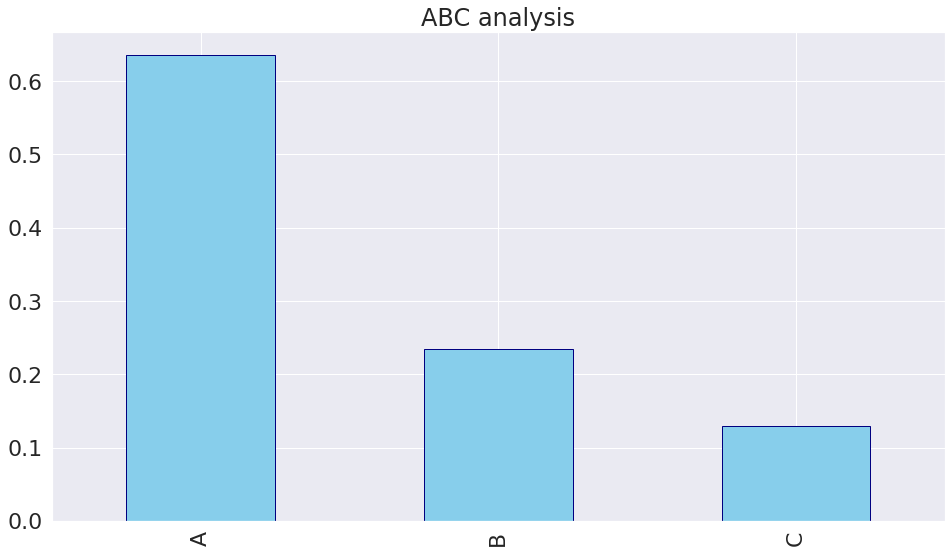

In [ ]:
# График доли категорий
volume_groups.plot(kind='bar', figsize=(16, 9), title='ABC analysis', color='skyblue', edgecolor='navy', grid=True)

### Вывод по ABC анализу

 Правило Парето не работает! Нужно искать другое распределение.


>Если увеличивать процент продаж для группы А, то количество аренд в группе А увеличивается, остальные группы уменьшаются. В итоге модель машинного обучения показывает хорошие результаты для группы А и неплохой accuracy, для остальных групп - хуже, так как мало экземпляров.


>Если уменьшать процент продаж для группы А, то группа А уменьшается, остальные увеличиваются. Accuracy падает, но percision и recall для B и С возрастают. Однако вручную подобрать оптимальное значение я не смогу, поэтому проведу дополнительный анализ.

Мой вариант: дополнительно провести XYZ анализ и итоговые группы сформировать следующим образом. К группе А отнести красные категории, B - жёлтые, С - синие.
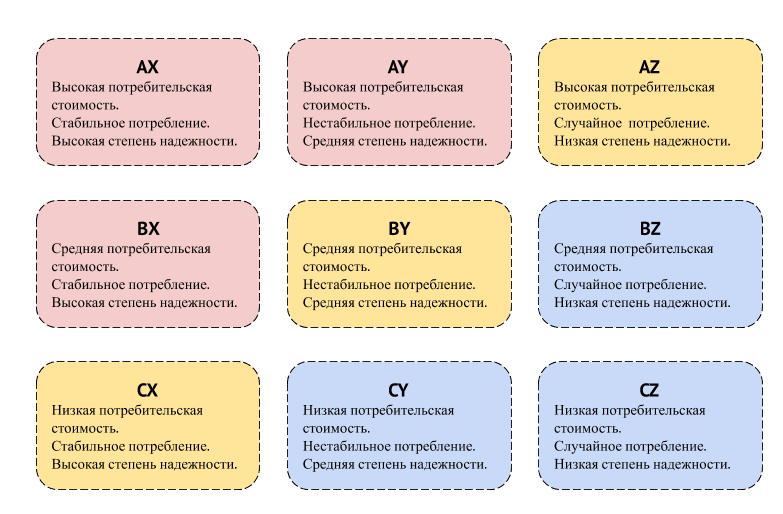

###XYZ анализ

In [ ]:
# Запрос на получение данных об арендах DVD
xyz_data = pd.read_sql_query("""SELECT title,
       rental_date
FROM   film 
       JOIN inventory
         ON film.film_id = inventory.film_id
       JOIN rental
         ON inventory.inventory_id = rental.inventory_id
       JOIN payment
         ON rental.rental_id = payment.rental_id 
                     """, conn)
xyz_data

,title,rental_date
0,Drumline Cyclone,2005-06-19 11:42:04
1,Drumline Cyclone,2005-06-16 18:01:36
2,Flight Lies,2005-06-17 08:19:22
3,Flight Lies,2005-06-16 06:03:33
4,Slacker Liaisons,2005-06-17 09:26:15
...,...,...
14591,Comancheros Enemy,2005-08-23 22:25:26
14592,Voyage Legally,2005-08-23 22:26:47
14593,Illusion Amelie,2005-08-23 22:42:48
14594,Hunchback Impossible,2005-08-23 22:43:07


In [ ]:
# Выделение номера недели для каждой записи об аренде
xyz_data['sales_week']=xyz_data['rental_date'].dt.week
xyz_data = xyz_data.drop(columns=['rental_date'])
xyz_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,title,sales_week
0,Drumline Cyclone,24
1,Drumline Cyclone,24
2,Flight Lies,24
3,Flight Lies,24
4,Slacker Liaisons,24
...,...,...
14591,Comancheros Enemy,34
14592,Voyage Legally,34
14593,Illusion Amelie,34
14594,Hunchback Impossible,34


In [ ]:
# Суммарное кол-во аренд для каждой недели и каждого фильма
orders = xyz_data.groupby(['sales_week', 'title'])
orders = orders.size()
orders

sales_week  title            
7           Ace Goldfinger       1
            Affair Prejudice     1
            African Egg          1
            Ali Forever          1
            Alone Trip           1
                                ..
34          Wyoming Storm        1
            Yentl Idaho          2
            Young Language       1
            Zoolander Fiction    2
            Zorro Ark            1
Length: 6166, dtype: int64

In [ ]:
# Проверка на отсутствие нулевых значений стандартного отклонения
orders = orders.groupby(level=1)
orders.std().value_counts()

1.000000    28
0.577350    26
0.500000    24
0.816497    24
0.447214    22
            ..
1.054093     1
1.832251     1
2.356602     1
2.073644     1
1.995531     1
Length: 272, dtype: int64

In [ ]:
# Расчёт волатильности
volatility = orders.std() / orders.mean()
volatility

title
Academy Dinosaur     0.471405
Ace Goldfinger       0.349927
Adaptation Holes     0.222681
Affair Prejudice     0.544331
African Egg          0.340151
                       ...   
Young Language       0.349927
Youth Kick           0.372678
Zhivago Core         0.000000
Zoolander Fiction    0.419877
Zorro Ark            0.478714
Length: 958, dtype: float64

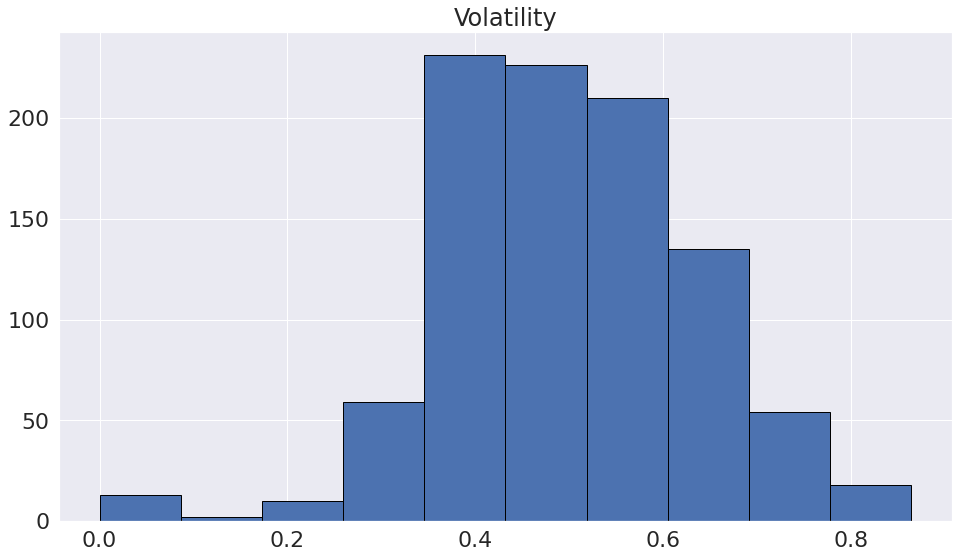

In [ ]:
# Гистограмма полученных значений
plt.title('Volatility')
volatility.hist(edgecolor='black')

На основе гистограммы определяю следующие группы:

X - <0.37

Y - >=0.37 and <0.6

Z - >=0.6

In [ ]:
# Функция определения категории фильма в XYZ анализе
def XYZ_analysis(cur):
  if cur < 0.37:
    return 'X'
  elif cur >= 0.37 and cur < 0.6:
    return 'Y'
  else:
    return 'Z'

In [ ]:
# Беру результаты ABC анализа
res = abc_data[['title', 'category']]
res

,title,category
746,Gleaming Jawbreaker,A
135,Apache Divine,A
833,Deer Virginian,A
818,Storm Happiness,A
80,Greatest North,A
...,...,...
176,Cruelty Unforgiven,C
287,Mixed Doors,C
61,Slacker Liaisons,C
461,Flight Lies,C


In [ ]:
# Соединяю результаты двух анализов
res = res.rename(columns={'category': 'ABC'})
res = res.set_index(['title'])
res['XYZ'] = volatility.apply(XYZ_analysis)
res['seq'] = res['ABC'] + res['XYZ']
res

,ABC,XYZ,seq
title,,,
Gleaming Jawbreaker,A,Y,AY
Apache Divine,A,Y,AY
Deer Virginian,A,Z,AZ
Storm Happiness,A,Y,AY
Greatest North,A,Z,AZ
...,...,...,...
Cruelty Unforgiven,C,X,CX
Mixed Doors,C,Y,CY
Slacker Liaisons,C,Z,CZ


In [ ]:
# Функция замены категорий ABC+XYZ анализа на новые категории A,B,C (в начале писале об этом + фотку прикрепил)
def new_ABC_analysis(cur):
  if cur in ('AX', 'AY', 'BX'):
    return 'A'
  elif cur in ('AZ', 'BY', 'CX'):
    return 'B'
  else:
    return 'C'

In [ ]:
# Добавление столбца с категориями
res['new_seq'] = res['seq'].apply(new_ABC_analysis)
res

,ABC,XYZ,seq,new_seq
title,,,,
Gleaming Jawbreaker,A,Y,AY,A
Apache Divine,A,Y,AY,A
Deer Virginian,A,Z,AZ,B
Storm Happiness,A,Y,AY,A
Greatest North,A,Z,AZ,B
...,...,...,...,...
Cruelty Unforgiven,C,X,CX,B
Mixed Doors,C,Y,CY,C
Slacker Liaisons,C,Z,CZ,C


### Итоговое распределение по категориям

In [ ]:
# Процентное соотношение категорий (A,B,C)
volume_groups = res['new_seq'].value_counts(normalize=True)
volume_groups
# Эти категории буду использовать в качестве меток классов модели машинного обучения

A    0.491099
B    0.388482
C    0.120419
Name: new_seq, dtype: float64

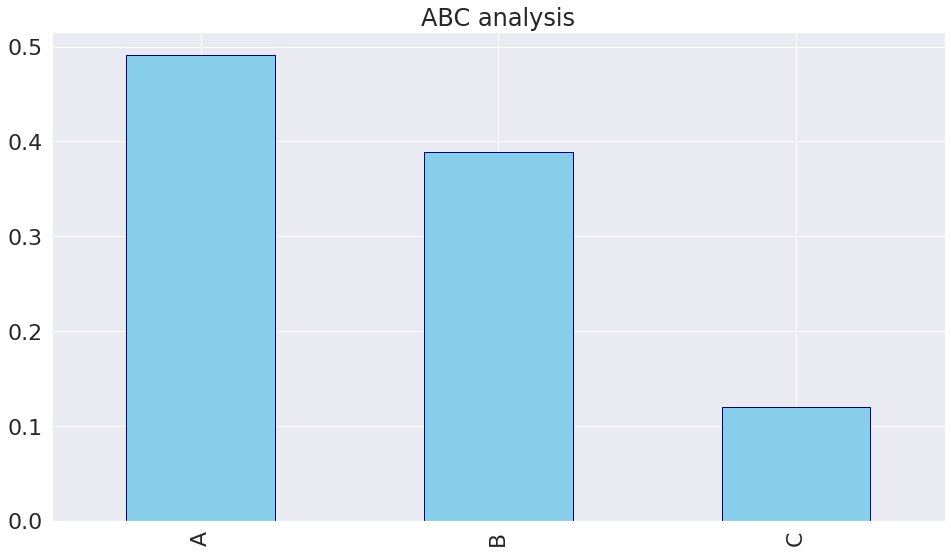

In [ ]:
# График доли категорий
volume_groups.plot(kind='bar', figsize=(16, 9), title='ABC analysis', color='skyblue', edgecolor='navy', grid=True)

In [ ]:
# Данные, которые дальше нужны будут для обучения модели
data = res['new_seq']
data

title
Gleaming Jawbreaker    A
Apache Divine          A
Deer Virginian         B
Storm Happiness        A
Greatest North         B
                      ..
Cruelty Unforgiven     B
Mixed Doors            C
Slacker Liaisons       C
Flight Lies            C
Drumline Cyclone       C
Name: new_seq, Length: 955, dtype: object

##Оценка среднего объёма недельной выручки
Задание: На основе полученного (общего) анализа ассортимента, оцените средний объем недельной выручки в каждой категории в привязке к дате начала аренды. В какой категории эта оценка имеет меньший разброс?

In [ ]:
# Запрос на получение фильмов, выручки по ним, дата начала аренды
revenue_data = pd.read_sql_query("""SELECT title,
       amount,
       rental_date
FROM   film 
       JOIN inventory
         ON film.film_id = inventory.film_id
       JOIN rental
         ON inventory.inventory_id = rental.inventory_id
       JOIN payment
         ON rental.rental_id = payment.rental_id 
                     """, conn)
revenue_data

,title,amount,rental_date
0,Drumline Cyclone,3.99,2005-06-19 11:42:04
1,Drumline Cyclone,0.99,2005-06-16 18:01:36
2,Flight Lies,5.99,2005-06-17 08:19:22
3,Flight Lies,4.99,2005-06-16 06:03:33
4,Slacker Liaisons,4.99,2005-06-17 09:26:15
...,...,...,...
14591,Comancheros Enemy,30.15,2005-08-23 22:25:26
14592,Voyage Legally,22.93,2005-08-23 22:26:47
14593,Illusion Amelie,31.00,2005-08-23 22:42:48
14594,Hunchback Impossible,21.93,2005-08-23 22:43:07


### Анализ данных

In [ ]:
# Типы данных
revenue_data.dtypes

title                  object
amount                float64
rental_date    datetime64[ns]
dtype: object

In [ ]:
# Хотел посмотреть первую и последнюю дату аренды, чтобы ориентрироваться какой период времени рассматривается
print('Rental date')
print('Min: ', revenue_data['rental_date'].min())
print('Max: ', revenue_data['rental_date'].max())

Rental date
Min:  2005-06-14 22:53:33
Max:  2006-02-14 15:16:03


In [ ]:
# Проверка на отсутствие нулевых значений
print(revenue_data['rental_date'].isnull().value_counts(), '\n')

False    14596
Name: rental_date, dtype: int64 



### Расчёт средней недельной выручки

In [ ]:
# Временной интервал меньше года, поэтому я не выделял год аренды, только неделю
revenue_data['rental_week']=revenue_data['rental_date'].dt.week
revenue_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,title,amount,rental_date,rental_week
0,Drumline Cyclone,3.99,2005-06-19 11:42:04,24
1,Drumline Cyclone,0.99,2005-06-16 18:01:36,24
2,Flight Lies,5.99,2005-06-17 08:19:22,24
3,Flight Lies,4.99,2005-06-16 06:03:33,24
4,Slacker Liaisons,4.99,2005-06-17 09:26:15,24
...,...,...,...,...
14591,Comancheros Enemy,30.15,2005-08-23 22:25:26,34
14592,Voyage Legally,22.93,2005-08-23 22:26:47,34
14593,Illusion Amelie,31.00,2005-08-23 22:42:48,34
14594,Hunchback Impossible,21.93,2005-08-23 22:43:07,34


In [ ]:
# Количество аренд по неделям
revenue_data['rental_week'].value_counts().sort_index()

7      182
24    1493
25     522
27    2501
28     956
30    3256
31    1314
33    3148
34    1224
Name: rental_week, dtype: int64

In [ ]:
# Соединение результата с данными о категория
revenue_data = revenue_data.merge(data, how='left', left_on='title', right_on='title').rename(columns={'new_seq':'category'})
revenue_data

,title,amount,rental_date,rental_week,category
0,Drumline Cyclone,3.99,2005-06-19 11:42:04,24,C
1,Drumline Cyclone,0.99,2005-06-16 18:01:36,24,C
2,Flight Lies,5.99,2005-06-17 08:19:22,24,C
3,Flight Lies,4.99,2005-06-16 06:03:33,24,C
4,Slacker Liaisons,4.99,2005-06-17 09:26:15,24,C
...,...,...,...,...,...
14591,Comancheros Enemy,30.15,2005-08-23 22:25:26,34,C
14592,Voyage Legally,22.93,2005-08-23 22:26:47,34,A
14593,Illusion Amelie,31.00,2005-08-23 22:42:48,34,A
14594,Hunchback Impossible,21.93,2005-08-23 22:43:07,34,B


In [ ]:
# Удаление стоблца с датами аренды, так как нужна только неделя аренды
# Проверка на пропуски
revenue_data = revenue_data.drop(columns=['rental_date'])
revenue_data.isnull().value_counts()

title  amount  rental_week  category
False  False   False        False       14512
                            True           84
dtype: int64

In [ ]:
# Удаляю строчки с пропусками
revenue_data = revenue_data.dropna()
revenue_data

,title,amount,rental_week,category
0,Drumline Cyclone,3.99,24,C
1,Drumline Cyclone,0.99,24,C
2,Flight Lies,5.99,24,C
3,Flight Lies,4.99,24,C
4,Slacker Liaisons,4.99,24,C
...,...,...,...,...
14591,Comancheros Enemy,30.15,34,C
14592,Voyage Legally,22.93,34,A
14593,Illusion Amelie,31.00,34,A
14594,Hunchback Impossible,21.93,34,B


In [ ]:
# Выручки для каждой категории по неделям
amount_category = revenue_data.groupby(['category', 'rental_week']).sum()
amount_category = amount_category.unstack(level=1)
amount_category

amount                     ...                              
rental_week       7         24       25  ...        31        33        34
category                                 ...                              
A            2663.08  24816.44  7504.60  ...  21911.21  42770.81  19890.53
B            1703.90  11827.11  5402.95  ...  10657.86  32236.14   9715.14
C             298.54   1290.45   576.61  ...   1418.13   4942.90   1834.25

[3 rows x 9 columns]

In [ ]:
amount_category.index

Index(['A', 'B', 'C'], dtype='object', name='category')

### Итоговые значения

In [ ]:
# Чтобы оценить отклонения по выручке в каждой категории, я считал какой процент от среднего составляет стандартное отклонение
for i in amount_category.index:
  val_mean = round(amount_category.loc[i].mean(),3)
  val_std = round(amount_category.loc[i].std(), 3)
  amount_category.loc[i, 'mean'] = val_mean
  amount_category.loc[i, 'std'] = val_std
  amount_category.loc[i, 'percent_std'] = val_std / val_mean
amount_category

amount                     ...       mean        std percent_std
rental_week        7        24       25  ...                                  
category                                 ...                                  
A            2663.08  24816.44  7504.60  ...  23871.046  14873.875    0.623093
B            1703.90  11827.11  5402.95  ...  15229.008  11541.335    0.757852
C             298.54   1290.45   576.61  ...   2243.313   1907.460    0.850287

[3 rows x 12 columns]

Вывод: чем важнее категория, тем меньше (относительно среднего) стандартное отклонение для недельной выручки

## Построение классификатора фильмов 
Задание: Используя оценки выручки из пункта 2 и категоризацию из пункта 1, постройте классификатор фильмов на основе актерского состава, языка, рейтинга (12+, 18+, см колонку rating) и продолжительности. При построении классификатора подберите пороговые значения для каждого класса так, чтобы максимизировать ожидаемую выручку. То-есть нужно предсказывать категории А,B,C. Дополнительно, при сравнении моделей воспользуйтесь построением доверительных интервалов (t интервалов) для оценки диапазона значений метрик качества для каждого классификатора.

Честно, мне лень копировать все блоки с кодом, чтобы показывать что, когда я использовал и какой результат получил, поэтому я покажу итоговый вариант, но прокоммментирую что пробовал применять, и что получил.

In [ ]:
# Запрос на получение рейтинга, продолжительности, языка, актёрского состава для каждого фильма
# Забегая вперёд скажу, что язык у всех фильмов одинаковый, поэтому использовать его в обучении бесполезно
# Вместо языка я использовал категории (жанры) фильмов (category_id)
# fulltext дал большой прирост по точности
# Пробовал добавлять столбец special_features, но лучше модель не становилась
model_data = pd.read_sql_query("""SELECT title,
       rating,
       length,
       language_id,
       actor_id,
       category_id, 
       fulltext
FROM  film_category
       JOIN film
         ON film_category.film_id=film.film_id
       JOIN film_actor
         ON film.film_id = film_actor.film_id; """, conn)
model_data

,title,rating,length,language_id,actor_id,category_id,fulltext
0,Academy Dinosaur,PG,86,1,1,6,'academi':1 'battl':15 'canadian':20 'dinosaur...
1,Anaconda Confessions,R,92,1,1,2,'anaconda':1 'australia':18 'confess':2 'denti...
2,Angels Life,G,74,1,1,13,'angel':1 'astronaut':11 'battl':14 'berlin':1...
3,Bulworth Commandments,G,61,1,1,10,'amaz':4 'bulworth':1 'command':2 'cow':9 'dis...
4,Cheaper Clyde,G,87,1,1,14,'ancient':19 'charact':5 'cheaper':1 'clyde':2...
...,...,...,...,...,...,...,...
5457,Telegraph Voyage,PG,148,1,200,12,'battl':14 'boat':20 'dog':11 'fate':4 'husban...
5458,Trojan Tomorrow,PG,52,1,200,14,'ancient':19 'astound':4 'boat':17 'husband':8...
5459,Virginian Pluto,R,164,1,200,6,'berlin':18 'boy':16 'crocodil':11 'dentist':8...
5460,Wardrobe Phantom,G,178,1,200,7,'action':5 'action-pack':4 'ancient':21 'astro...


### Анализ данных

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


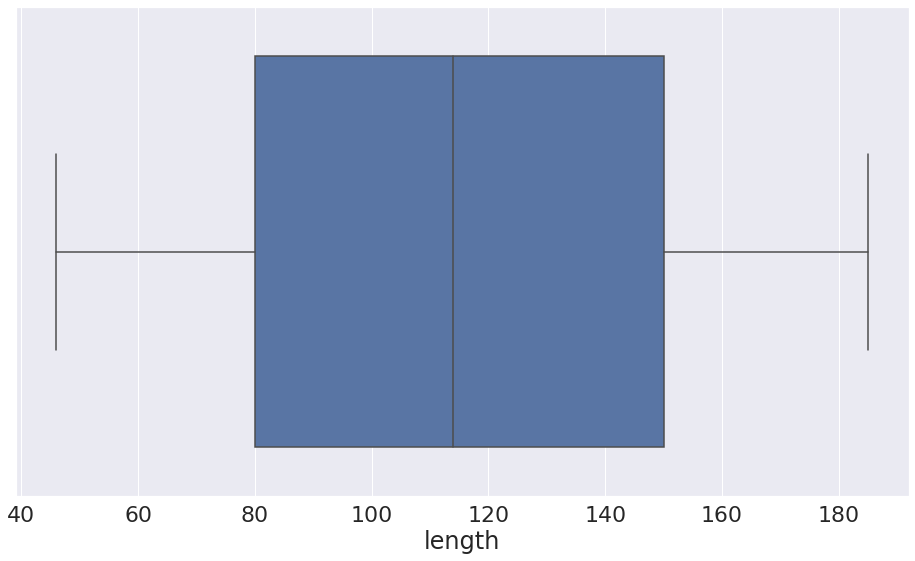

In [ ]:
# Проверка на наличие аномалий
sns.boxplot(model_data['length'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


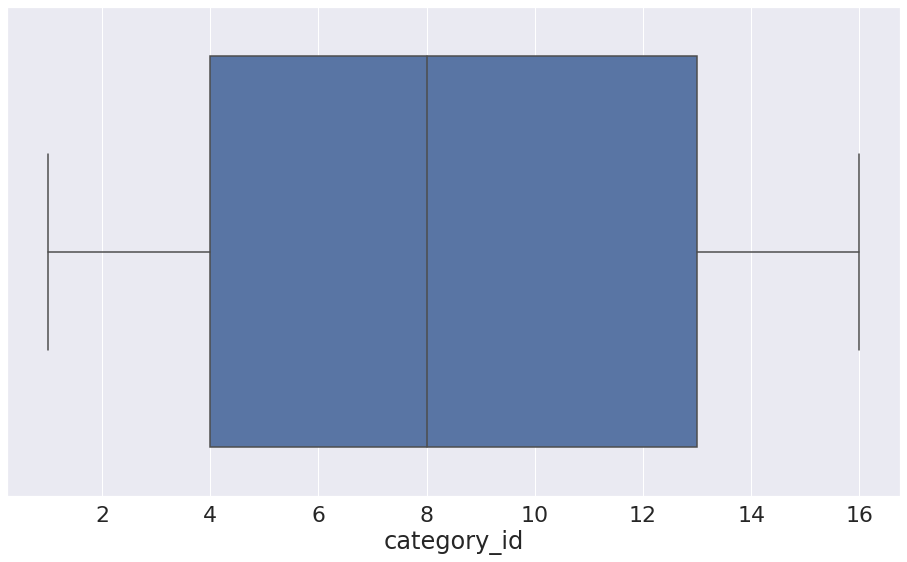

In [ ]:
sns.boxplot(model_data['category_id'])

In [ ]:
model_data['fulltext'].value_counts()

'australia':18 'cincinatti':2 'compos':16 'feminist':11 'fight':14 'insight':4 'lamb':1 'man':8 'must':13 'stori':5                     15
'abandon':19 'cat':11 'crystal':2 'dracula':1 'feminist':8 'find':14 'frisbe':16 'fun':20 'hous':21 'must':13 'reflect':5 'thrill':4    13
'australia':19 'charact':5 'creatur':2 'crocodil':9 'dentist':17 'fate':4 'meet':15 'monkey':12 'mummi':1 'must':14 'studi':6           13
'cat':16 'confront':14 'drama':5 'fate':4 'frisbe':8 'go':2 'must':13 'random':1 'shark':19 'student':11 'tank':20                      13
'administr':17 'boy':8 'crazi':1 'databas':16 'fanci':4 'home':2 'must':13 'outback':20 'panorama':5 'vanquish':14 'woman':11           13
                                                                                                                                        ..
'bride':1 'epic':4 'intrigu':2 'man':16 'monkey':11 'must':13 'new':18 'orlean':19 'robot':8 'tale':5 'vanquish':14                      1
'amaz':4 'crocodil':8 'expl

In [ ]:
model_data['language_id'].value_counts()
# Нет смысла использовать язык фильма в обучении, если он для всех одинаков

1    5462
Name: language_id, dtype: int64

In [ ]:
# Присоединение категорий A,B,C
# Удаление столбца с языками и названиями фильмов
model_data = model_data.merge(data, how='left', left_on='title', right_on='title').rename(columns={'new_seq':'category', 'category_id': 'genre'})
model_data = model_data.drop(columns=['title', 'language_id'])
model_data

,rating,length,actor_id,genre,fulltext,category
0,PG,86,1,6,'academi':1 'battl':15 'canadian':20 'dinosaur...,A
1,R,92,1,2,'anaconda':1 'australia':18 'confess':2 'denti...,A
2,G,74,1,13,'angel':1 'astronaut':11 'battl':14 'berlin':1...,A
3,G,61,1,10,'amaz':4 'bulworth':1 'command':2 'cow':9 'dis...,C
4,G,87,1,14,'ancient':19 'charact':5 'cheaper':1 'clyde':2...,A
...,...,...,...,...,...,...
5457,PG,148,200,12,'battl':14 'boat':20 'dog':11 'fate':4 'husban...,A
5458,PG,52,200,14,'ancient':19 'astound':4 'boat':17 'husband':8...,A
5459,R,164,200,6,'berlin':18 'boy':16 'crocodil':11 'dentist':8...,A
5460,G,178,200,7,'action':5 'action-pack':4 'ancient':21 'astro...,A


In [ ]:
# Проверка на наличие нулевых значений
model_data.isnull().value_counts()

rating  length  actor_id  genre  fulltext  category
False   False   False     False  False     False       5232
                                           True         230
dtype: int64

In [ ]:
# Удаление нулевых значений
model_data = model_data.dropna()
model_data

,rating,length,actor_id,genre,fulltext,category
0,PG,86,1,6,'academi':1 'battl':15 'canadian':20 'dinosaur...,A
1,R,92,1,2,'anaconda':1 'australia':18 'confess':2 'denti...,A
2,G,74,1,13,'angel':1 'astronaut':11 'battl':14 'berlin':1...,A
3,G,61,1,10,'amaz':4 'bulworth':1 'command':2 'cow':9 'dis...,C
4,G,87,1,14,'ancient':19 'charact':5 'cheaper':1 'clyde':2...,A
...,...,...,...,...,...,...
5457,PG,148,200,12,'battl':14 'boat':20 'dog':11 'fate':4 'husban...,A
5458,PG,52,200,14,'ancient':19 'astound':4 'boat':17 'husband':8...,A
5459,R,164,200,6,'berlin':18 'boy':16 'crocodil':11 'dentist':8...,A
5460,G,178,200,7,'action':5 'action-pack':4 'ancient':21 'astro...,A


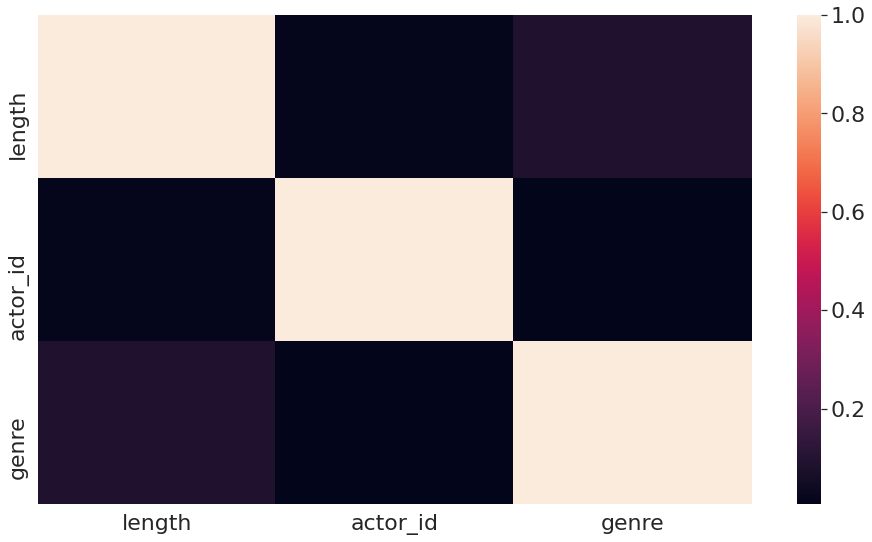

In [ ]:
# Проверка на наличие корреляций между значениями столбцов
sns.heatmap(model_data.corr())

In [ ]:
model_data.dtypes
# Нужно преобразовать типы из категориальных в числовые

rating      object
length       int64
actor_id     int64
genre        int64
fulltext    object
category    object
dtype: object

In [ ]:
# Функция кодирующая категориальные признаки числовыми значениями
def category_to_int(data):
    result = data.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

In [ ]:
# Кодировка признаков
encoded_data, encoders = category_to_int(model_data)
encoded_data

,rating,length,actor_id,genre,fulltext,category
0,2,86,1,6,101,0
1,4,92,1,2,308,0
2,0,74,1,13,400,0
3,0,61,1,10,290,2
4,0,87,1,14,363,0
...,...,...,...,...,...,...
5457,2,148,200,12,594,0
5458,2,52,200,14,345,0
5459,4,164,200,6,630,0
5460,0,178,200,7,112,0


In [ ]:
encoders
# Закодированы два столбца

{'category': LabelEncoder(),
 'fulltext': LabelEncoder(),
 'rating': LabelEncoder()}

In [ ]:
# labels - метки классов для обучения
labels = encoded_data['category'].values
labels

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
# Удаление меток классов из датасета
encoded_data = encoded_data.drop(columns=['category'])
encoded_data

,rating,length,actor_id,genre,fulltext
0,2,86,1,6,101
1,4,92,1,2,308
2,0,74,1,13,400
3,0,61,1,10,290
4,0,87,1,14,363
...,...,...,...,...,...
5457,2,148,200,12,594
5458,2,52,200,14,345
5459,4,164,200,6,630
5460,0,178,200,7,112


In [ ]:
# В последствии нужно будет для того, чтобы посмотреть важность признаков
feature = encoded_data.columns

### Разбиение на обучение и тест

In [ ]:
# Масштабирование
# Помогло увеличить точность модели
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(encoded_data)
encoded_data = scaler.transform(encoded_data)
encoded_data

array([[-0.02612647, -0.72553707, -1.75033675, -0.53672739, -1.33826507],
       [ 1.42036771, -0.57791378, -1.75033675, -1.39470407, -0.58523909],
       [-1.47262065, -1.02078366, -1.75033675,  0.96473181, -0.25056088],
       ...,
       [ 1.42036771,  1.19356574,  1.738635  , -0.53672739,  0.58613464],
       [-1.47262065,  1.53802009,  1.738635  , -0.32223322, -1.29824919],
       [ 0.69712062,  1.53802009,  1.738635  , -1.1802099 ,  0.57158341]])

In [ ]:
# Разделение данных на обучающую и тестовую выборки
train_data, test_data, train_labels, test_labels = train_test_split(encoded_data, labels, stratify=labels, test_size=0.3)

### Оценка работы модели на кросс валидации

In [ ]:
 # Разбиение на 5 фолдов
skf = StratifiedKFold(n_splits=5)

In [ ]:
# Функция кросс-валидация и подсчёта доли верных ответов 
# В качастве метрики для выбора лучшей модели была выбрана accuracy, хотя только по ней делать выводы некорректно, поскольку кол-во экземпляров классов разное
# Помимо accuracy, выводится подробный отчёт по precision и recall
# Думаю, в данной задаче важнее precision, чем recall
# Нам важнее верно определять класс фильмов (как можно меньше ошибок совершать), важнее с точки зрения выручки
# В итоге получилось, что модель которая лучше по accuracy, лучше и по другим метрикам
def learn_score(classifier, parameters):
  clf = GridSearchCV(classifier, param_grid=parameters, cv=skf, scoring='accuracy')
  clf.fit(train_data, train_labels)
  mean_values = clf.cv_results_['mean_test_score']
  std_values = clf.cv_results_['std_test_score']
  print('Accuracy on train data:')
  for i in range(len(mean_values)):
    print(str(clf.cv_results_['params'][i]) + ': ' + str(round(mean_values[i], 3)) + ' +/- ' + str(round(std_values[i], 3)))
  print('\n' + 'Best parameters: ' + str(clf.best_params_))
  # Построение доверительного интервала для accuracy (t интервалов)
  print('\n'+ 'Model mean accuracy 95% confidence interval: ' + str(_tconfint_generic(mean=mean_values.mean(), std_mean=mean_values.std(ddof=1)/sqrt(len(mean_values)), alpha=0.05, alternative='two-sided', dof=len(mean_values)-1)))
  print('\nDetailed classification report (test data):')
  print(classification_report(test_labels, clf.predict(test_data)))
  print('\n\n')
  return clf

In [ ]:
# Словарь с настройками для каждого классификатора
classifiers = {'KNN': {'n_neighbors': [2,3,4,5,6,7,8,9,10]},                                                                                 # Метод k ближайших соседей
               'DTC': {'criterion': ['gini', 'entropy'], 'max_depth': [2,3,4,5,6,7,8,9,10]},                                                 # Дерево решений
               'NB': {'priors': [None, [0.5, 0.32, 0.18], [0.5, 0.45, 0.05], [0.7, 0.2, 0.1], [0.6, 0.25, 0.15]]},                           # Наивный Байес
               'LR': {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'class_weight': ['balanced', None], 'max_iter': [100, 1000, 10000]},    # Логистическая регрессия
               'SVM': {'C': [1.0, 1.25, 1.5, 1.75, 2.0], 'class_weight': ['balanced', None], 'max_iter': [100, 1000, 10000]}}                # Метод опорных векторов

In [ ]:
# Обучение модели
learn_score(KNeighborsClassifier(), classifiers['KNN'])

Accuracy on train data:
{'n_neighbors': 2}: 0.677 +/- 0.016
{'n_neighbors': 3}: 0.664 +/- 0.014
{'n_neighbors': 4}: 0.638 +/- 0.008
{'n_neighbors': 5}: 0.63 +/- 0.007
{'n_neighbors': 6}: 0.623 +/- 0.02
{'n_neighbors': 7}: 0.614 +/- 0.022
{'n_neighbors': 8}: 0.615 +/- 0.015
{'n_neighbors': 9}: 0.603 +/- 0.014
{'n_neighbors': 10}: 0.6 +/- 0.009

Best parameters: {'n_neighbors': 2}

Model mean accuracy 95% confidence interval: (0.6092495815577593, 0.6495664393028574)

Detailed classification report (test data):
              precision    recall  f1-score   support

           0       0.69      0.88      0.78       768
           1       0.75      0.61      0.67       625
           2       0.74      0.35      0.48       177

    accuracy                           0.71      1570
   macro avg       0.73      0.61      0.64      1570
weighted avg       0.72      0.71      0.70      1570






GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
# Обучение модели
learn_score(DecisionTreeClassifier(), classifiers['DTC'])

Accuracy on train data:
{'criterion': 'gini', 'max_depth': 2}: 0.527 +/- 0.01
{'criterion': 'gini', 'max_depth': 3}: 0.539 +/- 0.012
{'criterion': 'gini', 'max_depth': 4}: 0.557 +/- 0.016
{'criterion': 'gini', 'max_depth': 5}: 0.561 +/- 0.015
{'criterion': 'gini', 'max_depth': 6}: 0.616 +/- 0.026
{'criterion': 'gini', 'max_depth': 7}: 0.629 +/- 0.026
{'criterion': 'gini', 'max_depth': 8}: 0.657 +/- 0.033
{'criterion': 'gini', 'max_depth': 9}: 0.713 +/- 0.031
{'criterion': 'gini', 'max_depth': 10}: 0.757 +/- 0.033
{'criterion': 'entropy', 'max_depth': 2}: 0.533 +/- 0.011
{'criterion': 'entropy', 'max_depth': 3}: 0.54 +/- 0.008
{'criterion': 'entropy', 'max_depth': 4}: 0.549 +/- 0.012
{'criterion': 'entropy', 'max_depth': 5}: 0.566 +/- 0.01
{'criterion': 'entropy', 'max_depth': 6}: 0.583 +/- 0.015
{'criterion': 'entropy', 'max_depth': 7}: 0.613 +/- 0.015
{'criterion': 'entropy', 'max_depth': 8}: 0.635 +/- 0.016
{'criterion': 'entropy', 'max_depth': 9}: 0.679 +/- 0.026
{'criterion': 'entr

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
     

In [ ]:
# Обучение модели
learn_score(GaussianNB(), classifiers['NB'])

Accuracy on train data:
{'priors': None}: 0.503 +/- 0.02
{'priors': [0.5, 0.32, 0.18]}: 0.496 +/- 0.008
{'priors': [0.5, 0.45, 0.05]}: 0.507 +/- 0.017
{'priors': [0.7, 0.2, 0.1]}: 0.489 +/- 0.0
{'priors': [0.6, 0.25, 0.15]}: 0.494 +/- 0.004

Best parameters: {'priors': [0.5, 0.45, 0.05]}

Model mean accuracy 95% confidence interval: (0.48878172308180273, 0.5068554890638075)

Detailed classification report (test data):
              precision    recall  f1-score   support

           0       0.53      0.67      0.59       768
           1       0.44      0.42      0.43       625
           2       0.00      0.00      0.00       177

    accuracy                           0.50      1570
   macro avg       0.32      0.36      0.34      1570
weighted avg       0.43      0.50      0.46      1570






/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None,
             param_grid={'priors': [None, [0.5, 0.32, 0.18], [0.5, 0.45, 0.05],
                                    [0.7, 0.2, 0.1], [0.6, 0.25, 0.15]]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
# Обучение модели
learn_score(LogisticRegression(), classifiers['LR'])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/

Accuracy on train data:
{'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1'}: nan +/- nan
{'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2'}: 0.399 +/- 0.016
{'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'elasticnet'}: nan +/- nan
{'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'none'}: 0.399 +/- 0.016
{'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1'}: nan +/- nan
{'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2'}: 0.399 +/- 0.016
{'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'elasticnet'}: nan +/- nan
{'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'none'}: 0.399 +/- 0.016
{'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l1'}: nan +/- nan
{'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2'}: 0.399 +/- 0.016
{'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'elasticnet'}: nan +/- nan
{'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'none'}: 0.399 +/- 0.01

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': ['balanced', None],
                         'max_iter': [100, 1000, 10000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
            

In [ ]:
# Обучение модели
learn_score(SVC(), classifiers['SVM'])

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base

Accuracy on train data:
{'C': 1.0, 'class_weight': 'balanced', 'max_iter': 100}: 0.113 +/- 0.001
{'C': 1.0, 'class_weight': 'balanced', 'max_iter': 1000}: 0.362 +/- 0.008
{'C': 1.0, 'class_weight': 'balanced', 'max_iter': 10000}: 0.491 +/- 0.009
{'C': 1.0, 'class_weight': None, 'max_iter': 100}: 0.452 +/- 0.033
{'C': 1.0, 'class_weight': None, 'max_iter': 1000}: 0.548 +/- 0.004
{'C': 1.0, 'class_weight': None, 'max_iter': 10000}: 0.549 +/- 0.01
{'C': 1.25, 'class_weight': 'balanced', 'max_iter': 100}: 0.119 +/- 0.012
{'C': 1.25, 'class_weight': 'balanced', 'max_iter': 1000}: 0.376 +/- 0.013
{'C': 1.25, 'class_weight': 'balanced', 'max_iter': 10000}: 0.495 +/- 0.011
{'C': 1.25, 'class_weight': None, 'max_iter': 100}: 0.439 +/- 0.016
{'C': 1.25, 'class_weight': None, 'max_iter': 1000}: 0.531 +/- 0.027
{'C': 1.25, 'class_weight': None, 'max_iter': 10000}: 0.554 +/- 0.014
{'C': 1.5, 'class_weight': 'balanced', 'max_iter': 100}: 0.122 +/- 0.014
{'C': 1.5, 'class_weight': 'balanced', 'max_it

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1.0, 1.25, 1.5, 1.75, 2.0],
                         'class_weight': ['balanced', None],
                         'max_iter': [100, 1000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

###Выбор наилучшего набора параметров на основе кросс валидации и обучение модели на всем наборе данных для обучения

In [ ]:
# Дерево решений - алгоритм, который показал лучшие результаты
# Обучаю эту модель (с оптимальными параметрами) на всём датасете
model = DecisionTreeClassifier(criterion='gini', max_depth=10)
model.fit(train_data, train_labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Сбор метрик на обучении и тесте

              precision    recall  f1-score   support

           0       0.73      0.86      0.79       768
           1       0.74      0.68      0.71       625
           2       0.86      0.45      0.59       177

    accuracy                           0.74      1570
   macro avg       0.78      0.66      0.70      1570
weighted avg       0.75      0.74      0.74      1570



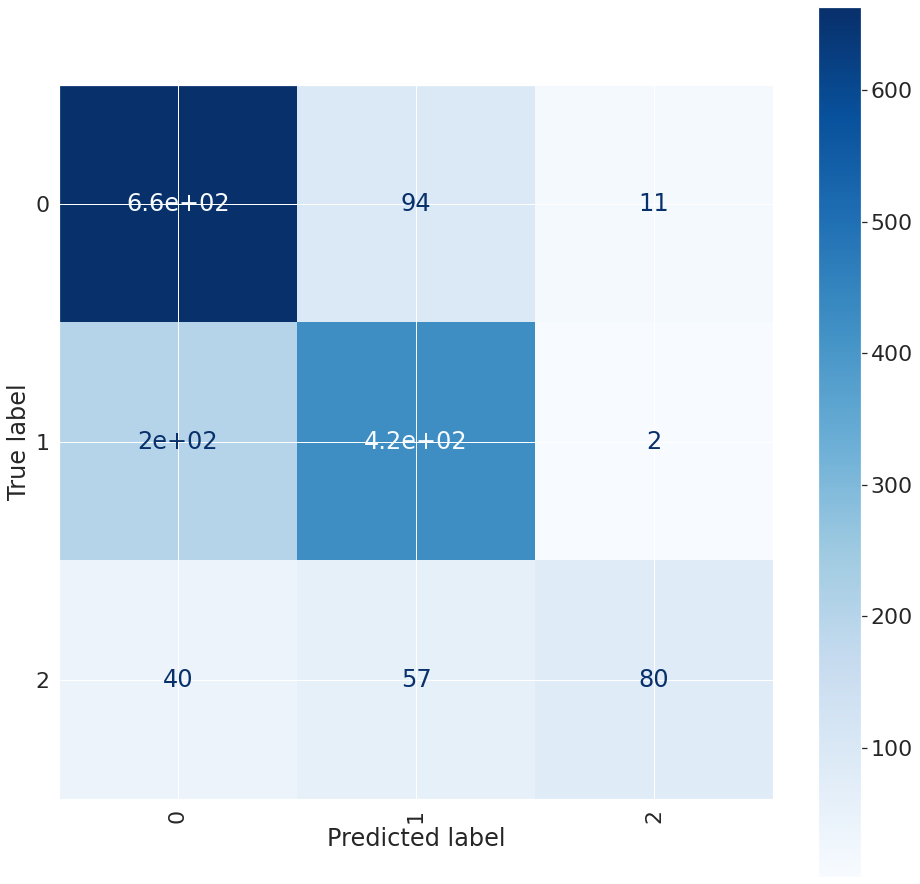

In [ ]:
print(classification_report(test_labels, model.predict(test_data)))
from sklearn.metrics import plot_confusion_matrix  
sns.set(rc={'figure.figsize':(16,16)}, font_scale=2)
plot_confusion_matrix(model, test_data, test_labels, display_labels=model.classes_, cmap=plt.cm.Blues, xticks_rotation='vertical')  
plt.show()

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       768
           1       0.99      0.98      0.99       625
           2       0.98      0.92      0.95       177

    accuracy                           0.98      1570
   macro avg       0.98      0.97      0.97      1570
weighted avg       0.98      0.98      0.98      1570



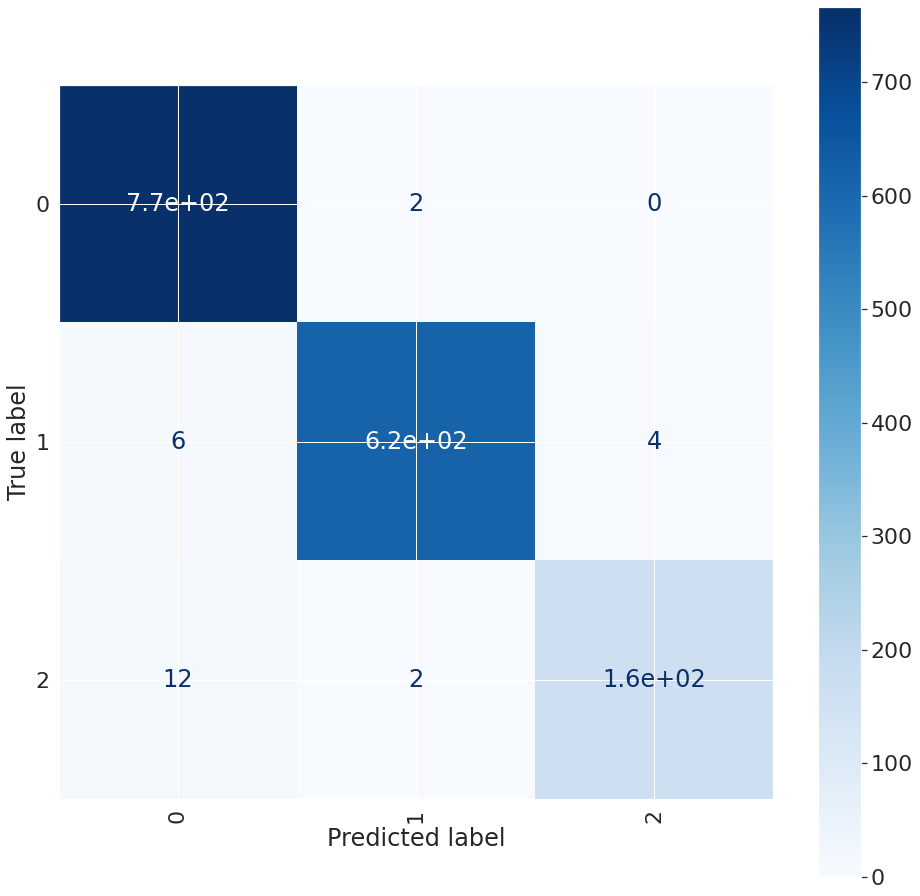

In [ ]:
# Ещё одна попытка получить хорошие результаты
clf = RandomForestClassifier()
clf.fit(train_data, train_labels)
print(classification_report(test_labels, clf.predict(test_data)))
plot_confusion_matrix(clf, test_data, test_labels, display_labels=clf.classes_, cmap=plt.cm.Blues, xticks_rotation='vertical')  
# Вау! Алгоритм без параметров сразу дал такие результаты

<BarContainer object of 5 artists>

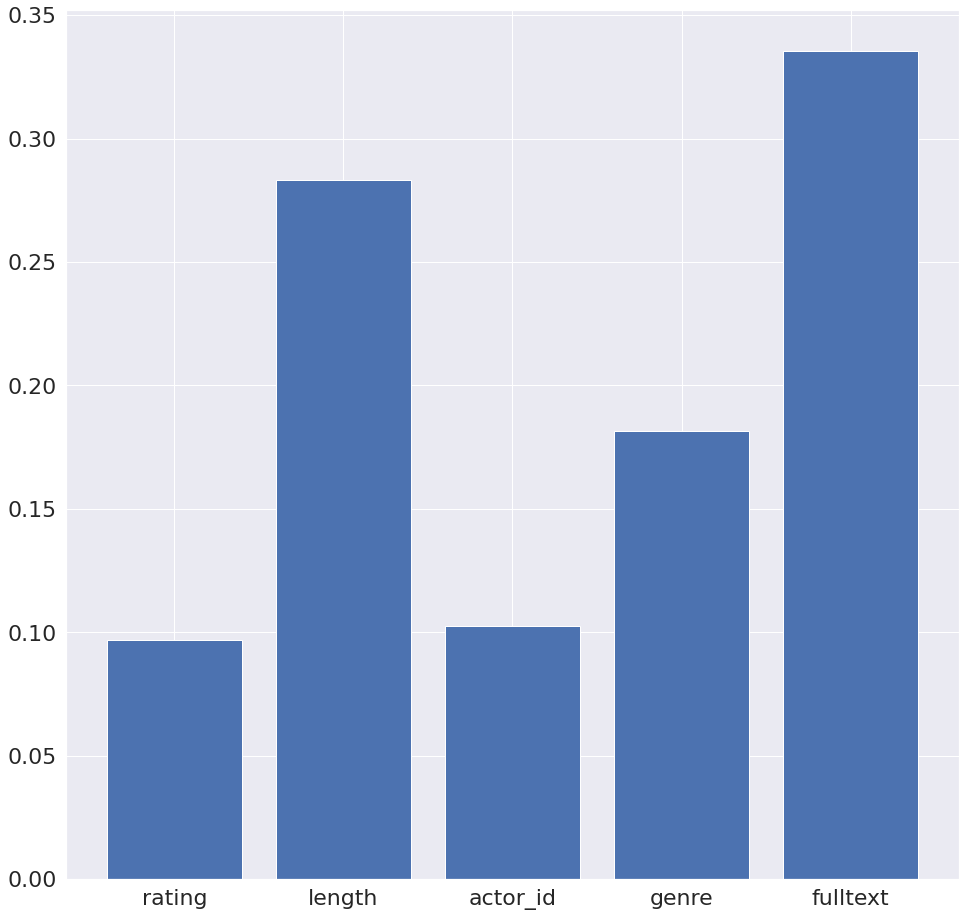

In [ ]:
# Столбчатая диаграмма важности каждого признака
plt.bar(feature, clf.feature_importances_)

### Подбор пороговых значений для каждого класса так, чтобы максимизировать ожидаемую выручку

In [ ]:
# Взятие вероятностей отнесения к классам
clf.predict_proba(test_data)
probs = clf.predict_proba(test_data)
probs = probs[:,1]
probs

array([0.11, 0.99, 0.3 , ..., 0.06, 0.07, 0.31])

При составлении формулы для расчёта оптимального порога я исходил из позиции, что магазин может зарабатывать меньше, чем возможно, а не терять. Поэтому в формуле нет отрицательных множителей, само значение множителя меняется.

Логика определения множителей:

**Класс А**

Выгоднее всегда выбирать фильмы из категории (класса) А. Фильмы категории А - это крупные мировые премьеры с известными режиссёрами, голливудскими актёрами. 
Чтобы получить максимальную выручку, их нужно покупать в период их выхода в прокат, в период наибольшего ажиотажа. Если купить их позже, то спрос будет ниже и вырочка, соответственно, меньше.

Чем ниже категория фильма, тем дольше он не будет добавлен в аренду (или вообще не будет добавлен). Если не будет фильмов категории А, то будут добавляться фильмы категории B и так далее.

Поэтому если модель ошибётся и определит фильм класса А, как фильм класса B, то магазин заработает меньше. Если модель классифицирует его как класс C, то выручка будет ещё меньше.

**Класс B**

Если модель ошибётся: классифицирует фильм как B, вместо А, то он поступит в продажу (аренду) вместо фильма категории А, следовательно магазин недозаработает.
Если модель ошибётся: классифицирует фильм как С, то он появится в продаже позже, магазин получит меньшую выручку.

**Класс С**

Логика такая, как и для предыдущих классов.

Если по ошибке модель отнесла фильм к категории А, то он (фильм) появится в продаже вместо фильма категории А. Спрос на него будет меньше и выручка-меньше.
Тоже самое, если по ошибке отнести фильм к категории B, но влияние на выручку меньше.

Таблица с множителя для расчёта представлена ниже.

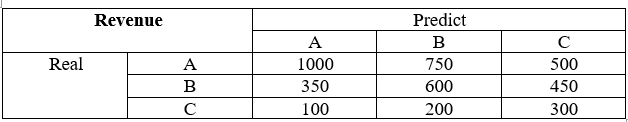

Maximum threshold: 0.45
Maximum revenue: 1157800


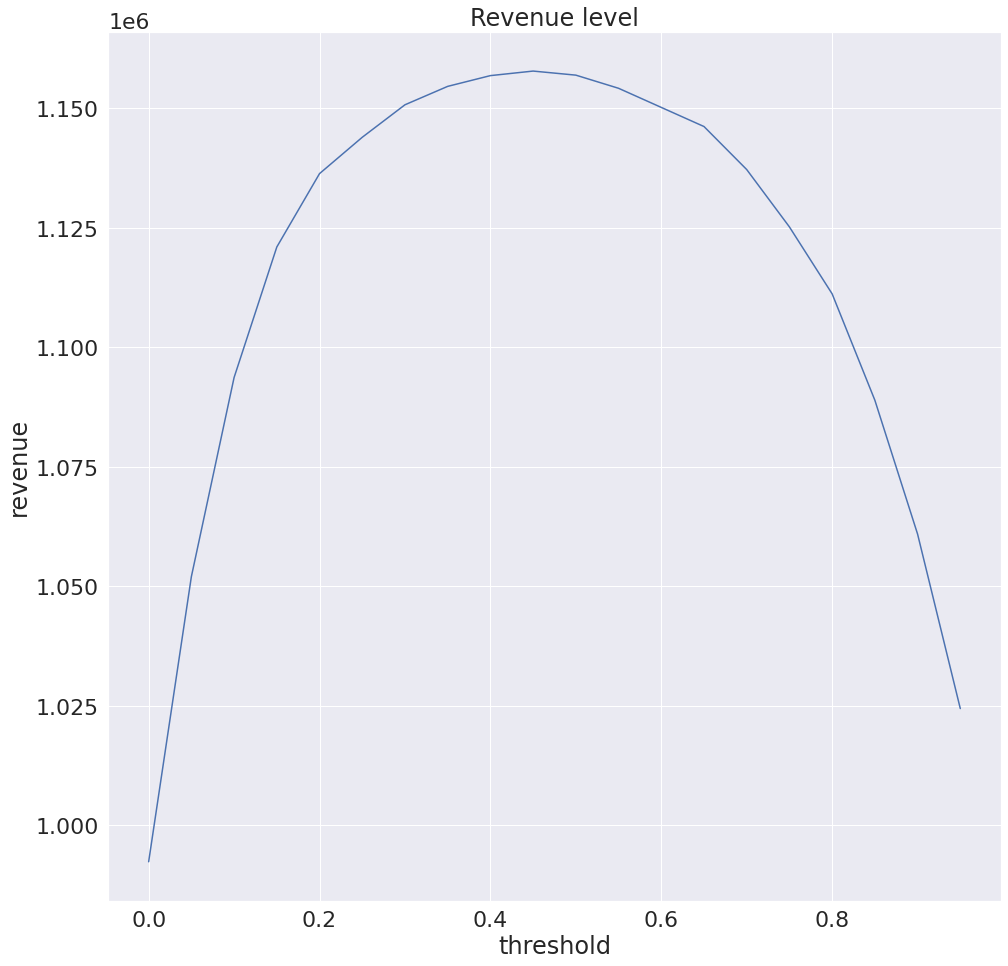

In [ ]:
# Определение оптимального значения порога
revenue = []
threshold = np.arange(0,1,0.05)
for t in threshold:
  mtx = confusion_matrix(test_labels, (probs > t).astype(np.int16))
  revenue.append(1000*mtx[0][0] + 350*mtx[1][0] + 100*mtx[2][0] + 750*mtx[0][1] + 600*mtx[1][1] + 200*mtx[2][1] + 500*mtx[0][2] + 450*mtx[1][2] + 300*mtx[2][2])

plt.ylabel('revenue')
plt.xlabel('threshold')
plt.title('Revenue level')
plt.plot(threshold, revenue)
max_value = np.max(revenue)
max_index = revenue.index(max_value)
print("Maximum threshold: {}".format(threshold[max_index]))
print("Maximum revenue: {}".format(max_value))

### Принятие решения

  По итогам работы получены хорошие результаты. Разработанная модель сможет с высокой точностью определять самые продаваемые и востребованные фильмы.

  Однако, по моему мнению, её нужно будет периодически переобучать. Модель учитывает актёрский состав фильма. Могут появится молодые популярные актёры или звёдный артист (режиссёр) может попасть в неприятную историю, испорить себе репутацию и спрос на фильмы с его участием упадёт.

  Также может меняться популярность тех или иных жанров фильмов. Ниже представлены графики популярности жанров кино по годам с 1918 по 2018.

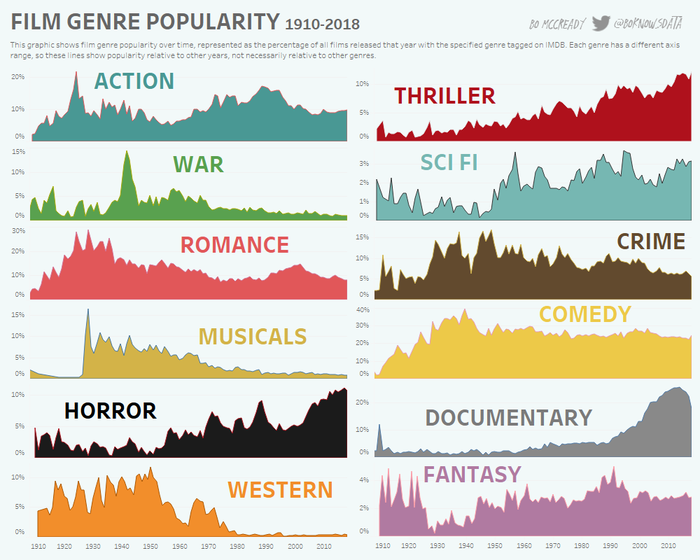

## Дэшборд
В redash постройте дэшборд, отражающий динамику о кол-ве заказов каждую неделю, а также информацию о том какие фильмы ожидают возвращения в магазин и о клиентах (телефон, email), которые должны их вернуть.

Ссылка на дэшборд в Redash: http://89.223.29.217/dashboard/project